# Multi-frequency inverse design
Last updated: 07/26/2020

Author: Siddharth Buddhiraju (sbuddhi@stanford.edu)

Based on ceviche with autograd by Tyler W. Hughes

Group of Professor Shanhui Fan, Stanford University

In [1]:
import numpy as np
import autograd.numpy as npa
import skimage as sk
import copy

import matplotlib as mpl
mpl.rcParams['figure.dpi']=100

import matplotlib.pylab as plt

from autograd.scipy.signal import convolve as conv
from skimage.draw import circle, circle_perimeter

import sys
sys.path.append('/Users/siddharthbuddhiraju/Google Drive/Research/invdes/mf/ceviche')
import ceviche.viz
from ceviche import fdfd_ez, fdfd_mf_ez, jacobian
from ceviche.optimizers import adam_optimize
from ceviche.modes import insert_mode
# from ceviche.helper import operator_proj, operator_blur 

import collections
# Create a container for our slice coords to be used for sources and probes
Slice = collections.namedtuple('Slice', 'x y')

In [2]:
# Speed of light in vacuum
c0 = 3e+8
# Angular frequency of the source in Hz
# omega = 2*np.pi*243*1e12
omega=243e12 #rad/s and not THz, typo in the actual paper
# Modulation frequency 
Omega=132e12 #rad/s and not THz, typo in the actual paper
# Number of sidebands on each side of central wavelength (total number of bands: 2*Nsb + 1)
Nsb = 1
# Spatial resolution in meters
dl=50e-9
# Number of pixels in the PMLs in each direction
Npml=10
# Background permittivity
eps_bg=1.0
# Waveguide structure's relative permittivity
eps_si=12.25
#  Modulation depth range
delta_min=0.0
delta_max=1.0
# Modulation phase range
phi_min = 0
phi_max = 2 * np.pi
# Number of modulation frequencies (different from number of sidebands) 
Nfreq = 1
# Full width of simulation domain
W=4e-6
# Waveguide thickness
wg_width=1.1e-6
# Central section thickness
wc=2.0e-6
# Full length of simulation domain
L=55e-6
# Length of modulation region on each side
Lmod=19e-6
#Length of central section
Lmid=4.75e-6
# Number of pixels in x-direction
Nx=int(L/dl)
# Number of pixels in y-direction
Ny=int(W/dl) 
# Space between the PMLs and the design region (in pixels)
space=20
# Length in pixels of the source/probe slices on each side of the center point
slice_width=3*wg_width

print('Simulation domain is ' + str(Nx) + 'x' + str(Ny) + ' pixels')

Simulation domain is 1100x80 pixels


### Optimization parameters

In [3]:
# Radius of the smoothening features
blur_radius=2
# Number of times to apply the blur
N_blur=1
# Strength of the binarizing projection
beta=50.0
# Middle point of the binarizing projection
eta=0.5
# Number of times to apply the blur
N_proj=1
# Number of epochs in the optimization 
Nsteps=50
# Step size for the Adam optimizer
step_size=1e-2

## Utility functions
### Projection and blur

In [4]:
# Projection that drives rho towards a "binarized" design with values either 0 or 1 
def operator_proj(rho, eta=0.5, beta=100, N=1):
    """Density projection
    eta     : Center of the projection between 0 and 1
    beta    : Strength of the projection
    N       : Number of times to apply the projection
    """
    for i in range(N):
        rho =  npa.divide(npa.tanh(beta * eta) + npa.tanh(beta * (rho - eta)), 
                          npa.tanh(beta * eta) + npa.tanh(beta * (1 - eta)))
    
    return rho

# Blurring filter that results in smooth features of the structure
# First we define a function to create the kernel
def _create_blur_kernel(radius):
    """Helper function used below for creating the conv kernel"""
    rr, cc = circle(radius, radius, radius+1)
    kernel = np.zeros((2*radius+1, 2*radius+1), dtype=np.float)
    kernel[rr, cc] = 1
    return  kernel/kernel.sum()

def operator_blur(rho, radius=2, N=1):
    """Blur operator implemented via two-dimensional convolution
    radius    : Radius of the circle for the conv kernel filter
    N         : Number of times to apply the filter
    
    Note that depending on the radius, the kernel is not always a
    perfect circle due to "pixelation" / stair casing
    """
    kernel = _create_blur_kernel(radius)
    if len(np.shape(rho)) == 3:
        Nfreq = np.shape(rho)[0]
        kernel = np.kron(np.ones([Nfreq,1,1]), kernel)/Nfreq
        for i in range(N):
            # For whatever reason HIPS autograd doesn't support 'same' mode, so we need to manually crop the output
            rho = conv(rho, kernel, mode='full')[:,radius:-radius,radius:-radius]
    else:
        kernel = _create_blur_kernel(radius)
        for i in range(N):
        # For whatever reason HIPS autograd doesn't support 'same' mode, so we need to manually crop the output
            rho = conv(rho, kernel, mode='full')[radius:-radius,radius:-radius]
    return rho

### Initialization, simulation and visualization

In [5]:
def init_domain():
    """Initializes the domain and design region

    space       : The space between the PML and the structure
    wg_width    : The feed and probe waveguide width
    space_slice : The added space for the probe and source slices
    """
    
    # Background permittivity initialization of the structure
    epsr = np.ones((Nx, Ny)) * eps_bg
    
    ## Waveguide
    # Left waveguide section
    wg_L1 = 0
    wg_L2 = int(Nx/2) - int(Lmid/2/dl)
    # Right waveguide section
    wg_R1 = int(Nx/2) + int(Lmid/2/dl)
    wg_R2 = int(Nx)
    wg_top = int(Ny/2) + int(wg_width/2/dl)
    wg_bot = int(Ny/2) - int(wg_width/2/dl)
    #Central section
    wg_c_top = int(Ny/2) + int(wc/2/dl)
    wg_c_bot = int(Ny/2) - int(wc/2/dl)

    # Left probe slice
    left_slice = Slice(x=np.array(Npml+1), 
        y=np.arange(int(Ny/2) - int(slice_width/2/dl), int(Ny/2) + int(slice_width/2/dl)))
    
    # Right probe slice
    right_slice = Slice(x=np.array(Nx-Npml-1), 
        y=np.arange(int(Ny/2) - int(slice_width/2/dl), int(Ny/2) + int(slice_width/2/dl)))

    # Dielectric profile
    epsr[wg_L1:wg_L2, wg_bot:wg_top] = eps_si
    epsr[wg_R1:wg_R2, wg_bot:wg_top] = eps_si
    epsr[wg_L2:wg_R1, wg_c_bot:wg_c_top] = eps_si
    
    # Design region for changing delta, phi
    design_region = np.zeros((Nx, Ny))
    design_region[wg_L2-int(Lmod/dl):wg_L2, wg_bot:wg_top] = 1
    design_region[wg_R1:wg_R1+int(Lmod/dl), wg_bot:wg_top] = 1
    
    # Modulation region
    rho_delta = np.random.rand(Nfreq, Nx, Ny)
    rho_phi = np.random.rand(Nfreq, Nx, Ny)
    for f in np.arange(Nfreq):
        rho_delta[f,:,:] = rho_delta[f,:,:] * design_region
        rho_phi[f,:,:] = rho_phi[f,:,:] * design_region

    return epsr, rho_delta, rho_phi, left_slice, right_slice, design_region


def poynting_flux(Hy, Ez, field_slice):
    S = -0.5 * Ez * npa.conj(Hy)
    Sr = npa.real(S*1e20)
    power_out = np.zeros(2*Nsb+1)
    for band in np.arange(-Nsb,Nsb+1):
        power_out[band+Nsb] = np.sum(Sr[band+Nsb][field_slice.x][field_slice.y])
    return power_out


def parameterize(rho, min_val, max_val, design_region):
    """Utility function for combining the design region epsr and the background epsr
    """
    rho = operator_blur(rho, radius=blur_radius, N=N_blur)
    rho = operator_proj(rho, beta=beta, eta=eta, N=N_proj)
    
    return ( min_val + (max_val-min_val) * rho ) * design_region


def viz_sim(omega, epsr, source, delta, phi, orders, slices=[], show=True):
    """Solve and visualize a simulation with permittivity 'epsr'
    """
    assert np.all(orders <= Nsb) and np.all(orders >= -Nsb), "-Nsb < orders < Nsb"
    simulation = fdfd_mf_ez(omega, dl, epsr, Omega, delta, phi, Nsb, [Npml, Npml])
    Hx, Hy, Ez = simulation.solve(source)

    fig, ax = plt.subplots(4,1, constrained_layout=True, figsize=(12,6))
    ceviche.viz.real(Ez[Nsb + orders[0]], outline=epsr, ax=ax[0], cbar=False)
    ceviche.viz.real(Ez[Nsb + orders[1]], outline=epsr, ax=ax[1], cbar=False)    
    for sl in slices:
        ax[0].plot(sl.x*np.ones(len(sl.y)), sl.y, 'b-')
        ax[0].plot(sl.x*np.ones(len(sl.y)), sl.y, 'b-')
    ceviche.viz.real(delta[0], ax=ax[2], cmap='Greys')
    ceviche.viz.real(phi[0], ax=ax[3], cmap='Greys')
    if show is True:
        plt.show()
    else:
        plt.close()
        
    S = -0.5 * Ez * npa.conj(Hy)
    Sr = npa.real(S*1e20)
    power_in = np.zeros(2*Nsb+1)
    power_out = np.zeros(2*Nsb+1)
    for band in np.arange(-Nsb,Nsb+1):
        power_in[band+Nsb] = np.sum(Sr[band+Nsb][slices[0].x + 1][slices[0].y])
        power_out[band+Nsb] = np.sum(Sr[band+Nsb][slices[1].x][slices[1].y])
        
    return (simulation, ax, power_in, power_out)

## Initial structure

We can visualize what our starting device looks like and how it behaves. Our device is initialized by the `init_domain()` function which was defined several cells above.

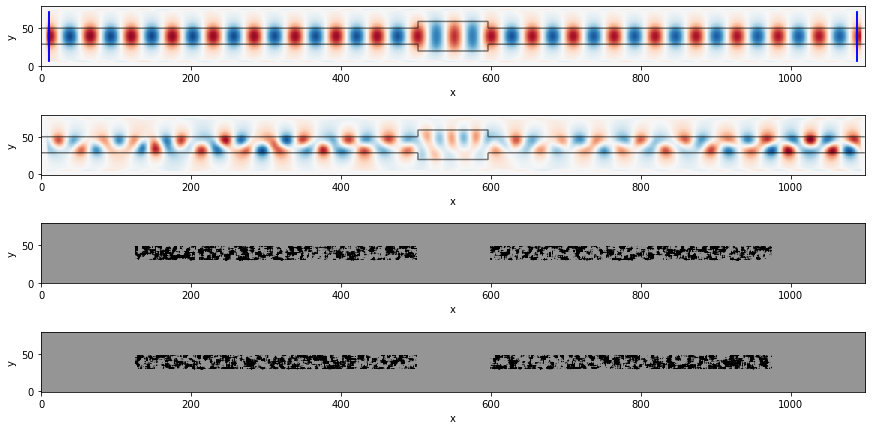

In [6]:
# Initialize the parametrization rho and the design region
epsr, rho_delta, rho_phi, left_slice, right_slice, design_region = init_domain()

delta = parameterize(rho_delta, delta_min, delta_max, design_region)
phi = parameterize(rho_phi, phi_min, phi_max, design_region)

# Setup source and pad appropriately
source_0 = insert_mode(omega, dl, left_slice.x, left_slice.y, epsr, m=1)
pad = np.zeros([Nsb,Nx,Ny])
source = np.concatenate( (np.concatenate((pad, np.array([source_0]))), pad) )

simulation, ax, power_in, power_out = viz_sim(omega, epsr, source, delta, phi, np.array([0, 1]), slices=[left_slice,right_slice],show=True)

## Define objective function

We will now define our objective function. This is a scalar-valued function which our optimizer uses to improve the device's performance.

Our objective function will consist of maximizing an overlap integral of the field in the output waveguide of the simulated device and the field of the waveguide's second order mode. The function takes in a single argument, `epsr` and returns the value of the overlap integral. The details of setting the permittivity and solving for the fields happens inside the objective function.

In [7]:
def mode_overlap(f, g):
    """Defines an overlap integral between the simulated field and desired field
    """
    return npa.abs(npa.sum(npa.conj(f)*g))

pad_left = np.zeros([Nsb+1,Nx,Ny])
pad_right = np.zeros([Nsb-1,Nx,Ny])
target_1 = insert_mode(omega, dl, right_slice.x, right_slice.y, epsr, m=2)
target = np.concatenate( (np.concatenate((pad_left, np.array([target_1]))), pad_right) )

def objective(params):
    rho = params.reshape(2*Nfreq, Nx, Ny)
    rho_delta = rho[0:Nfreq, :, :]
    rho_phi = rho[Nfreq:, :, :]
    simulation.delta = parameterize(rho_delta, delta_min, delta_max, design_region)
    simulation.phi = parameterize(rho_phi, phi_min, phi_max, design_region)
    _, _, Ez = simulation.solve(source)    
#     S = -0.5 * Ez * npa.conj(Hy)
#     Sr = npa.real(S*1e20)
#     power_out = npa.zeros(2*Nsb+1)
#     power_out = npa.sum(Sr[:, right_slice.x, right_slice.y],axis=1)
#     objective_fn = power_out[Nsb+1]
    return mode_overlap(Ez, target)*1e10
#     return objective_fn

## Run optimization

Now we can run our optimization. Note that we need to define our simulation object *outside* of the objective function and before the optimization is started.

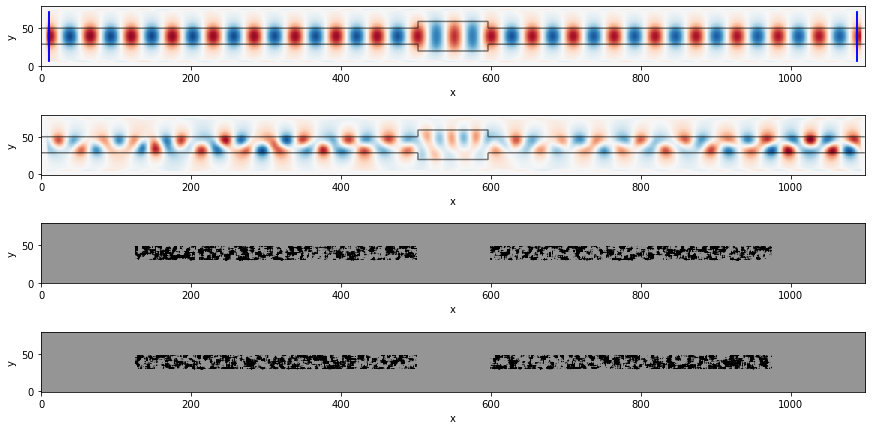

In [8]:
# Simulate initial device
simulation, ax, pow_bef_in, pow_bef_out = viz_sim(omega, epsr, source, delta, phi, np.array([0, 1]), slices=[left_slice, right_slice])

# Compute the gradient of the objective function using revere-mode differentiation
objective_jac = jacobian(objective, mode='reverse')

# Define initialization parameters
params = np.random.rand(2*Nfreq*Nx*Ny)

In [11]:
# Maximize the objective function using an ADAM optimizer
(params, loss) = adam_optimize(objective, params, objective_jac,
                         Nsteps=5, direction='max', step_size=5e-3)

Epoch:   1/  5 | Duration: 3.31 secs | Value: 1.825986e+04
Epoch:   2/  5 | Duration: 3.14 secs | Value: 2.083084e+04
Epoch:   3/  5 | Duration: 3.08 secs | Value: 2.289223e+04
Epoch:   4/  5 | Duration: 3.15 secs | Value: 2.471123e+04
Epoch:   5/  5 | Duration: 3.28 secs | Value: 2.632361e+04


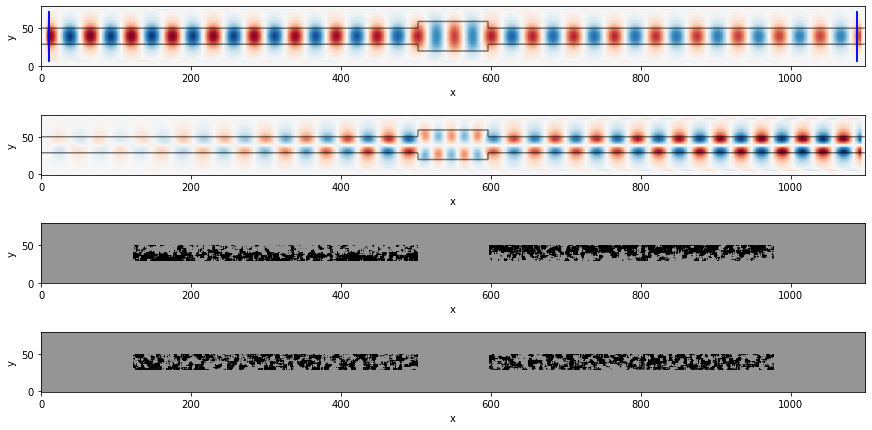

In [12]:
params_optimum = params.reshape(2*Nfreq, Nx, Ny)
delta_optimum = parameterize(params_optimum[0:Nfreq,:,:], delta_min, delta_max, design_region)
phi_optimum = parameterize(params_optimum[Nfreq:,:,:], phi_min, phi_max, design_region)
simulation, ax, pow_aft_in, pow_aft_out = viz_sim(omega, epsr, source, delta_optimum, phi_optimum, np.array([0, 1]), slices=[left_slice, right_slice])